# Trigonometry

Very often in a radio we need to compute the magnitude or phase of a wave (represented in the complex domain). 

This can be expensive to do precisely, but approximations are usually good enough for our purposes.

Per usual, we should start off with some imports:

In [1]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from alldigitalradio.trig import MagnitudeApproximator
from alldigitalradio.io.numpy import make_callable, take_n

# Magnitude

Magnitude, or more formally "L2 Norm" requires squaring and square roots (and also addition, but that's cheap).

I found in some paper I've long forgotten an approximation I think pulled from a textbook that is implemented entirely with comparisons, adders and shifts.

To evaluate this, let's generate a sweep from zero to 2pi in the complex domain, with an increasing magnitude

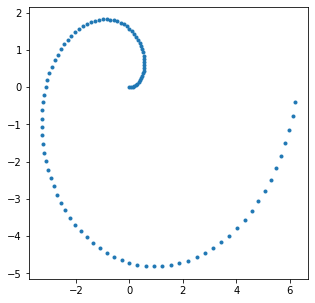

In [2]:
p = np.arange(0, 2*np.pi, 2*np.pi/100)              
inputs = p*np.exp(1j*p)
plt.figure(figsize=(5,5))
plt.plot(np.real(inputs), np.imag(inputs), '.')

Now let's push this through the `MagnitudeApproximator` and plot the approximate magnitude versus the actual magnitude

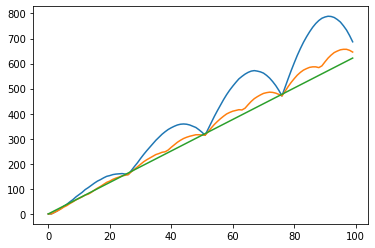

In [5]:
# (Blue) - First we'll use the simplest approximation, which is just an L1 norm
approximator = make_callable(MagnitudeApproximator(simple=True))
plt.plot([approximator(int(np.real(s)*100), int(np.imag(s)*100)) for s in inputs])

# (Orange) - Next we'll used the improved approximation (with the shifts and adds and comparisons)
approximator = make_callable(MagnitudeApproximator())
plt.plot([approximator(int(np.real(s)*100), int(np.imag(s)*100)) for s in inputs])

# (Green) Finally, the actual magnitude
plt.plot(np.abs(inputs*100))

All in all, we can see a decent amount of error, but the second (non-"simple" approach) is directionally correct enough for our purposes.

# CORDIC

Cordic is an old but brilliant algorithm to compute a variety of trigonometric functions using just shifts and adds. Perhaps I will explain later... after I've gotten everything to work.

In [109]:
from nmigen import Elaboratable, Module, Signal, signed

class Cordic(Elaboratable):
    """
    This is a pipelined CORDIC implementation that computes
    one result per clock cycle at a latency dependent on the
    number of stages.
    """
    def __init__(self, bit_depth=16, stages=8):
        self.bit_depth = bit_depth
        self.stages = stages
        
        self.input_x = Signal(signed(bit_depth))
        self.input_y = Signal(signed(bit_depth))
        
        self.magnitude = Signal(signed(bit_depth))
        self.angle = Signal(signed(bit_depth))
        
        self.output_x = Signal(signed(bit_depth))
        self.output_y = Signal(signed(bit_depth))
        
    def elaborate(self, platform):
        m = Module()
        
        cur_x = self.input_x
        cur_y = self.input_y
        cur_angle = Signal(signed(self.bit_depth))
        K = 1
        
        for i in range(self.stages):
            next_x = Signal(signed(self.bit_depth))
            next_y = Signal(signed(self.bit_depth))
            next_angle = Signal(signed(self.bit_depth))
            K *= np.cos(np.arctan(2**-i))
            angle = int(2**(self.bit_depth - 2)*np.arctan(2**-i))
            
            with m.If(cur_y < 0):
                m.d.sync += [
                    next_x.eq(cur_x - (cur_y >> i)),
                    next_y.eq(cur_y + (cur_x >> i)),
                    next_angle.eq(cur_angle - angle)
                ]
            with m.Else():
                m.d.sync += [
                    next_x.eq(cur_x + (cur_y >> i)),
                    next_y.eq(cur_y - (cur_x >> i)),
                    next_angle.eq(cur_angle + angle)
                ]
            
            cur_x = next_x
            cur_y = next_y
            cur_angle = next_angle
            
        #print(K)
            
        m.d.comb += [
            self.magnitude.eq(cur_x),
            self.angle.eq(cur_angle),
            
            self.output_x.eq(cur_x),
            self.output_y.eq(cur_y),
        ]
        return m

for n in range(10):
    c = Cordic(stages=n)
    c = make_callable(c, inputs=[c.input_x, c.input_y], outputs=[c.output_x, c.output_y, c.angle])
    x, y, angle = [c(30,60) for i in range(n+1)][-1]
    print(x, y, int(np.rad2deg(angle/2**14)))

0 0 0
90 30 44
105 -15 71
109 11 57
110 -2 64
111 4 61
111 1 62
111 0 63
111 0 64
111 0 64


In [105]:
def cordic(x, y, stages=10):
    angle = 0
    K = 1
    print(np.abs(x + 1j*y), np.rad2deg(np.arctan2(y, x)))
    for i in range(stages):
        #print(np.rad2deg(np.arctan(2**-i)))
        K *= np.cos(np.arctan(2**-i))
        if y < 0:
            xn = x - y*2**-i
            yn = y + x*2**-i
            angle = angle - np.arctan(2**-i)
        else:
            xn = x + y*2**-i
            yn = y - x*2**-i
            angle = angle + np.arctan(2**-i)
        x = int(xn)
        y = int(yn)
        print(x, y, int(np.rad2deg(angle)))
    print(x*K, y*K, np.rad2deg(angle))

cordic(30, 60)

67.08203932499369 63.43494882292201
90 30 45
105 -15 71
108 11 57
109 -2 64
109 4 61
109 0 62
109 -1 63
109 0 63
109 0 63
109 0 63
66.19061199879641 0.0 63.650676008087295
